In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
import random
import time

In [2]:
# Custom Dataset Class for Flower Images
class FlowerDataset(Dataset):
    def __init__(self, images_path, labels, transform=None):
        self.images_path = images_path
        self.labels = labels
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_path, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx] - 1  # Labels are 1-indexed in .mat file
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Helper function to load labels from the .mat file
def load_labels(mat_file_path):
    print(f"Loading labels from {mat_file_path}")
    labels = loadmat(mat_file_path)['labels'][0]
    return labels

In [4]:
# Dataset and Dataloader functions
def get_datasets(root_path):
    mat_file_path = os.path.join(root_path, "imagelabels.mat")
    labels = load_labels(mat_file_path)
    images_path = os.path.join(root_path, "jpg")

    dataset = FlowerDataset(images_path, labels, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))

    # Split dataset into train and validation (e.g., 80-20 split)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    return train_dataset, val_dataset

In [5]:
def get_data_loaders(train_dataset, val_dataset, batch_size=128):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [6]:
# Training function for feature extraction and fine-tuning
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=8, mode="Feature Extraction"):
    best_val_accuracy = -float('inf')
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    print(f"Starting {mode} for {num_epochs} epochs.")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"best_resnet50_model_{mode.replace(' ', '_').lower()}.pth")

        scheduler.step()

        # Print epoch info
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Training Loss: {train_loss:.6f}, Training Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Best Validation Accuracy so far: {best_val_accuracy:.2f}%")
        print(f"<<<<<<<<<<<<<<<<<<<-------------- End of Epoch {epoch + 1} ---------------->>>>>>>>>>>>>>>>>>>>>>>>")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
# Plotting training and validation metrics in a single graph
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def predict_random_images(model, dataset, device, num_images=10):
    model.eval()
    # Replace with actual flower names, ensure there are 102 entries
    label_names = [f"Flower_{i + 1}" for i in range(102)]
    
    chosen_indices = random.sample(range(len(dataset)), num_images)

    for idx in chosen_indices:
        image, label = dataset[idx]
        input_image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_image)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted_label = torch.max(probabilities, 1)

        # Ensure indices are valid
        predicted_label_idx = predicted_label.item()
        if predicted_label_idx < len(label_names):
            predicted_label_name = label_names[predicted_label_idx]
        else:
            predicted_label_name = f"Unknown Label {predicted_label_idx}"

        actual_label_idx = label
        if actual_label_idx < len(label_names):
            actual_label_name = label_names[actual_label_idx]
        else:
            actual_label_name = f"Unknown Label {actual_label_idx}"

        confidence_score = confidence.item() * 100

        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title(f"Predicted: {predicted_label_name} ({confidence_score:.2f}%)\nActual: {actual_label_name}")
        plt.axis('off')
        plt.show()

Loading labels from ./imagelabels.mat
Starting Feature Extraction for 16 epochs.
Epoch [1/16], Training Loss: 4.261789, Training Accuracy: 9.91%, Validation Loss: 3.752297, Validation Accuracy: 21.79%
Best Validation Accuracy so far: 21.79%
<<<<<<<<<<<<<<<<<<<-------------- End of Epoch 1 ---------------->>>>>>>>>>>>>>>>>>>>>>>>
Epoch [2/16], Training Loss: 3.197744, Training Accuracy: 36.73%, Validation Loss: 2.793542, Validation Accuracy: 44.32%
Best Validation Accuracy so far: 44.32%
<<<<<<<<<<<<<<<<<<<-------------- End of Epoch 2 ---------------->>>>>>>>>>>>>>>>>>>>>>>>
Epoch [3/16], Training Loss: 2.319081, Training Accuracy: 54.60%, Validation Loss: 2.095860, Validation Accuracy: 58.24%
Best Validation Accuracy so far: 58.24%
<<<<<<<<<<<<<<<<<<<-------------- End of Epoch 3 ---------------->>>>>>>>>>>>>>>>>>>>>>>>
Epoch [4/16], Training Loss: 1.691660, Training Accuracy: 68.86%, Validation Loss: 1.544183, Validation Accuracy: 70.63%
Best Validation Accuracy so far: 70.63%
<<<<<<

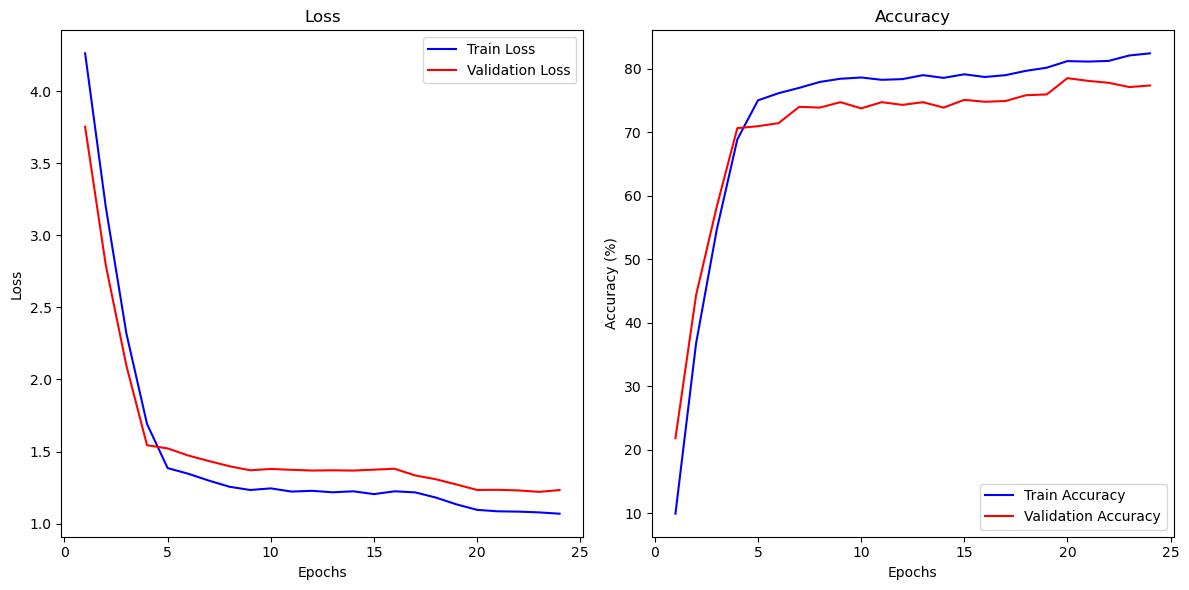

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


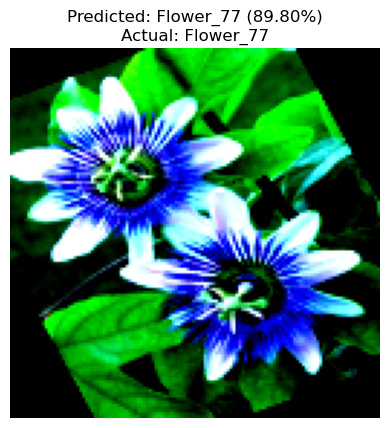

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


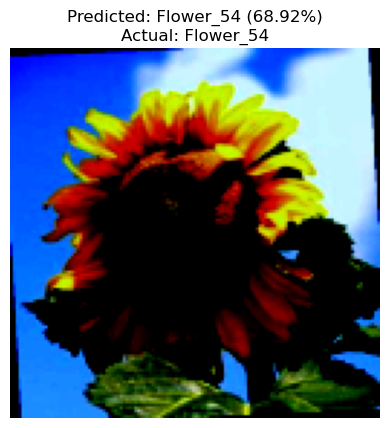

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


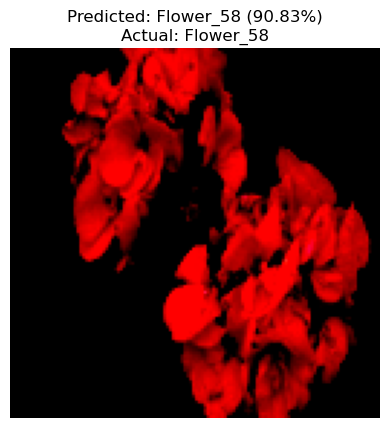

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


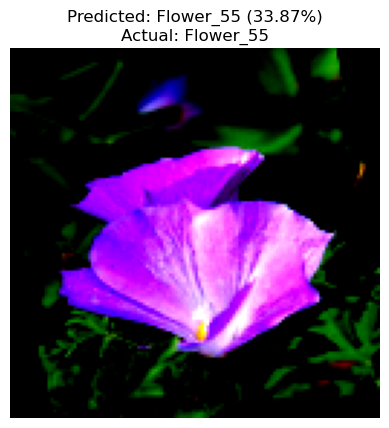

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


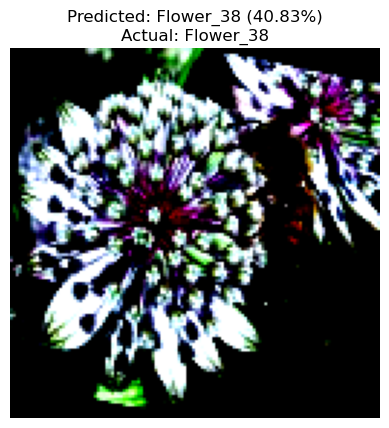

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


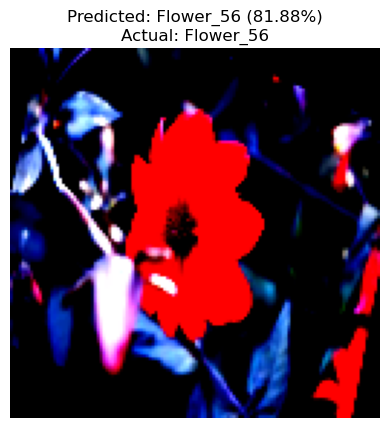

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


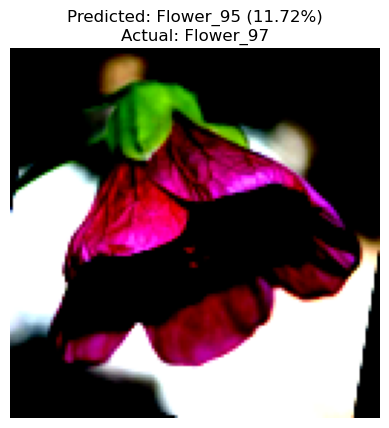

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


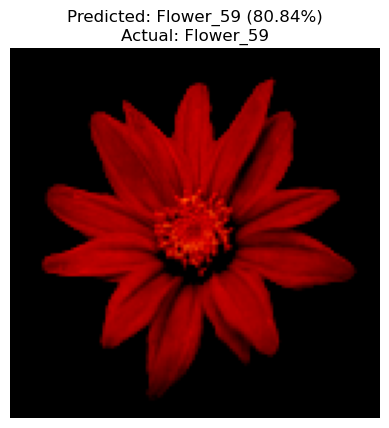

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


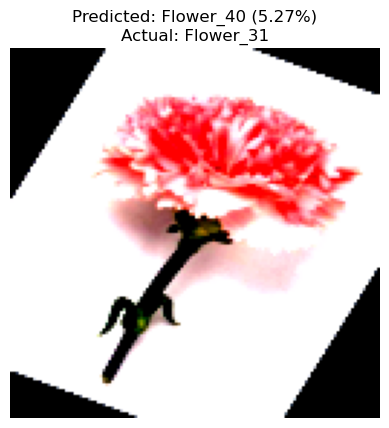

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


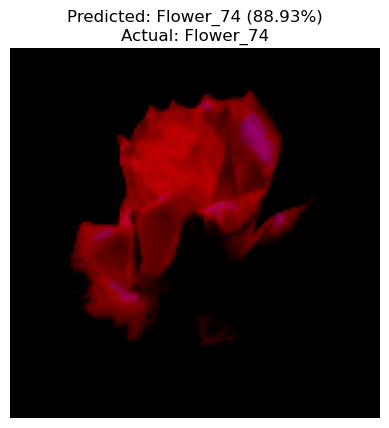

In [9]:
# Main execution
if __name__ == "__main__":
    ROOT_DIR = "./"
    train_dataset, val_dataset = get_datasets(ROOT_DIR)
    train_loader, val_loader = get_data_loaders(train_dataset, val_dataset, batch_size=128)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, 102)  # 102 flower classes

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    # Feature extraction phase
    start_time = time.time()
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=16, mode="Feature Extraction"
    )

    # Fine-tuning phase
    print("Running fine-tuning for 8 epochs")
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Adjust learning rate for fine-tuning
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    ft_train_losses, ft_val_losses, ft_train_accuracies, ft_val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=8, mode="Fine-Tuning"
    )
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    print(f"Average time per epoch: {total_time / 24:.2f} seconds")

    # Combine and plot metrics
    combined_train_losses = train_losses + ft_train_losses
    combined_val_losses = val_losses + ft_val_losses
    combined_train_accuracies = train_accuracies + ft_train_accuracies
    combined_val_accuracies = val_accuracies + ft_val_accuracies
    plot_metrics(combined_train_losses, combined_val_losses, combined_train_accuracies, combined_val_accuracies, num_epochs=24)

    # Predict and display random images
    predict_random_images(model, train_dataset, device, num_images=10)
